## Analyze token trees build from the hierarchical chunking process

### Load the result from the chunking trees and rebuild them

In [1]:
from hierarchical_chunker_utilities_GPT4 import *

dr          = os.getcwd()
results_dir = os.path.join(dr, "data", "labov_trees", "k=4")
stats_all = tree_analysis(results_dir, model='gpt-4o')
print(f"Analyzed {len(stats_all)} trees.")

for story_name, info in stats_all.items():
    print(f"{story_name}: {info['num_tokens']} tokens")

stats_all['youngest'].keys()

Analyzed 26 trees.
Shambaugh: 134 tokens
Boyscout: 169 tokens
Schissel: 183 tokens
schissel_v1-pool: 189 tokens
Tarentino: 198 tokens
Dalphonso: 228 tokens
CI: 282 tokens
DAlmaggio: 300 tokens
triplett_v1-rookie: 305 tokens
Triplett: 306 tokens
Laidlaw: 308 tokens
Williams: 331 tokens
McCaffrey: 332 tokens
Guyton: 349 tokens
Hawkins: 497 tokens
Furlow: 544 tokens
hester_v1-park: 571 tokens
Hester: 639 tokens
Adamo: 741 tokens
doSomething: 805 tokens
bear: 1180 tokens
Stein: 1756 tokens
Norman: 1869 tokens
Knott: 1926 tokens
Costa: 2311 tokens
youngest: 2331 tokens


dict_keys(['num_tokens', 'chunk_sizes', 'distribution', 'nodes_per_level', 'branching_ratios', 'partition'])

### To re-compute the theory curves, run the following (takes about 30min)

In [2]:
# import numpy as np

# # 1. Define data points and L values
# N_pts_log = np.logspace(np.log10(5), np.log10(2500), 20).astype(int)
# L_pts = np.arange(2, 12, 1)

# # 2. Compute theory curves and store in a dict
# theory = {}
# for L in L_pts:
#     print(f"Calculating theory for L={L}...")
#     theory[L] = {
#         'N': N_pts_log,
#         'Cn': [C_n(N, L) for N in N_pts_log],
#         'C01': [C_01(N, L) for N in N_pts_log]
#     }

In [3]:
# # 5. Save the theory data to a JSON file

# # Convert numpy types to Python primitives
# serializable_theory = {
#     int(L): {
#         'N': vals['N'].tolist(),
#         'Cn': vals['Cn'],
#         'C01': vals['C01']
#     }
#     for L, vals in theory.items()
# }
# # Write out JSON
# theory_path = os.path.join(dr, 'data', 'theory_data_k=4.json')
# with open(theory_path, 'w', encoding='utf-8') as f:
#     json.dump(serializable_theory, f, indent=2)

### Load the pre-computed theory curves

In [4]:
from RTM_Theory_utilities import *
import json
import os

# wherever you defined dr before, make sure it's set again:
dr = os.getcwd()
theory_path = os.path.join(dr, "data", "theory_data_k=4.json")

# 1. Load from disk
with open(theory_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

# 2. (Optional) Convert JSON string keys back to int
theory = {int(L): vals for L, vals in raw.items()}

In [5]:
import matplotlib.pyplot as plt
import matplotlib
# Set Matplotlib parameters
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 20

my_red = np.array([255, 99, 71]) / 255
my_blue = np.array([100, 149, 237]) / 255
my_green = '#42f5b3'

# 4. Grid-plot helper for L=3..10
def plot_grid_stats(theory, stats, L_start=2, L_end=11, show01=False):
    """
    Plot theory vs data across a 2x4 grid for L from L_start to L_end inclusive.
    """
    Ls = list(range(L_start, L_end + 1))
    n_plots = len(Ls)
    n_rows, n_cols = 2, 5  # 10 subplots: 2 rows, 5 columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=False, sharey=False)
    axes = axes.flatten()

    tree_Cs = []
    tree_Ns = []

    for story_name, info in stats.items():
        # Collect C values and N for each story
        tree_Cs.append(info['nodes_per_level'])
        tree_Ns.append(info['num_tokens'])

    for idx, L in enumerate(Ls):
        ax = axes[idx]
        # Theory curve
        ax.plot(
            theory[L]['N'], theory[L]['Cn'],
            '--',color=my_red,linewidth=6,
            label=f'$L={L}$ (theory)'
        )
        if show01:
            ax.plot(
                theory[L]['N'], theory[L]['C01'],
                '--',color=my_green,linewidth=7.5,
                label=f'$L={L}$ (theory C01)'
            )
        # Plot data with NaNs for missing
        data_vals = [Cs[L-1] if (isinstance(Cs, (list, np.ndarray)) and len(Cs) > L-1) else np.nan for Cs in tree_Cs]
        ax.scatter(
            tree_Ns,
            data_vals,
            s=80,color=my_blue, label=f'$L={L}$ (data)'
        )
        ax.set_title(f'$L={L}$')
        ax.set_xlabel('$N$')
        ax.set_ylabel('$C$')
        ax.set_ylim([0, np.nanmax(data_vals) * 2 if L<=10 else np.max(theory[L]['Cn']) * 2])
        ax.legend(
            fontsize=0.8 * plt.rcParams['font.size'],
            markerscale=0.8,
            labelspacing=0.8,
            handlelength=1.0,
            handletextpad=0.4,
            borderpad=0.5,
            borderaxespad=0.5,
            loc='upper right'
        )
    # Hide unused subplots if any
    for ax in axes[n_plots:]:
        ax.axis('off')

    plt.tight_layout()
    return fig, axes

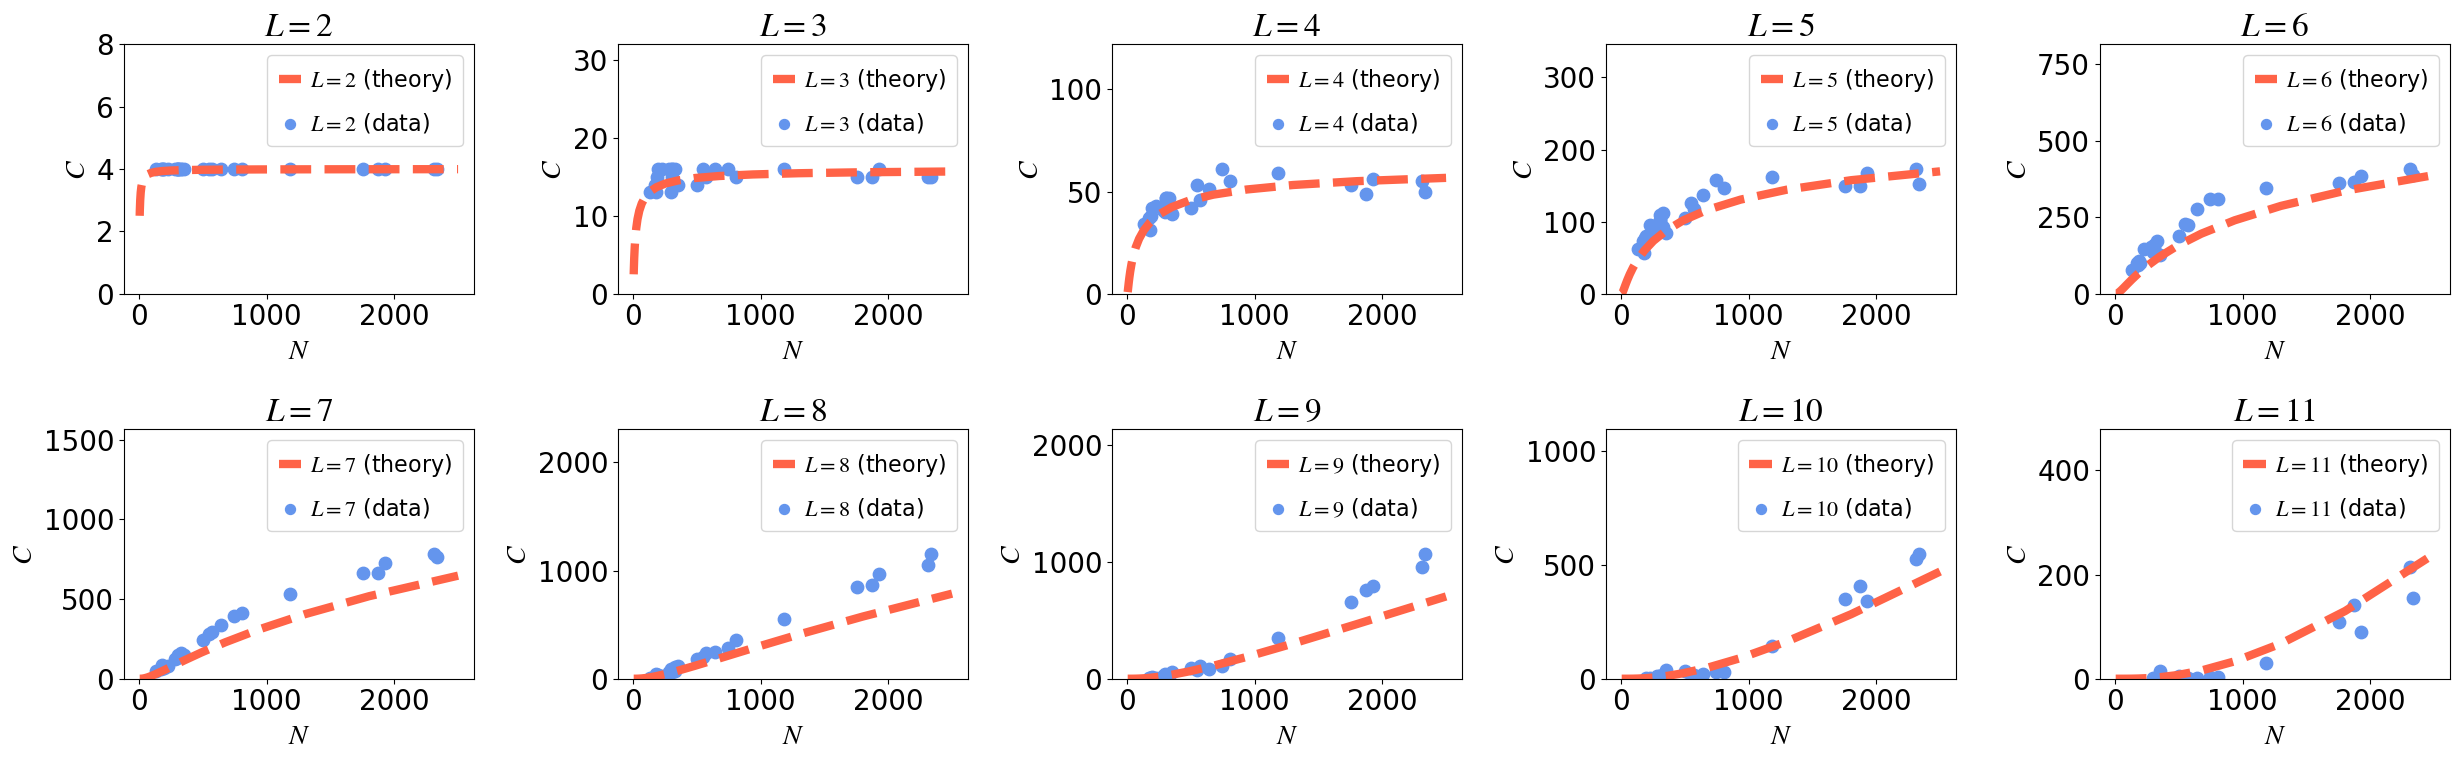

In [6]:
fig, axes = plot_grid_stats(theory,stats_all)
plt.show()

### Compare normalized chunk size distributions

In [7]:
import numpy as np

L_pts = np.arange(2, 12, 1)

# Prepare dicts instead of lists
dists_data = {}
bin_edges  = {}
N_data     = {}
s_data   = {}

for L in L_pts:
    dists, edges, Ns, s_samples = collect_level_data(stats_all, L)
    dists_data[L] = dists
    bin_edges[L]  = edges
    N_data[L]     = Ns
    s_data[L]     = s_samples

# Build the counts dict directly from the dict
level_counts = {L: len(N_data[L]) for L in L_pts}

# Or skip the intermediate dict and print straight away
for L in L_pts:
    print(f"Level {L}: {len(N_data[L])} stories")

Level 2: 26 stories
Level 3: 26 stories
Level 4: 26 stories
Level 5: 26 stories
Level 6: 26 stories
Level 7: 26 stories
Level 8: 25 stories
Level 9: 22 stories
Level 10: 15 stories
Level 11: 8 stories


### To recompute the distribution curves, run the following (takes ~30min)

In [8]:
# import numpy as np

# # 1. Define data points and L values
# L_pts = np.arange(2, 12, 1)

# # 2. Compute theory curves and store in a dict
# theory_dist = {}
# for L in L_pts:
#     print(f"Calculating theory for L={L}...")
#     theory_dist[L] = {
#         'N': Ns,
#         'distn': [node_dist_n(N, L, k=4) for N in N_data[L]],
#         'dist0': [node_dist_0(N, L, k=4) for N in N_data[L]],
#         'dist01': [node_dist_01(N, L, k=4) for N in N_data[L]]
#     }

In [9]:
# serializable_theory_dist = {}
# for L, vals in theory_dist.items():
#     # ensure we have a proper int key
#     key = int(L)

#     # Convert N (a list of ints or numpy scalars) → list of plain ints
#     N_list = [int(x) for x in vals["N"]]

#     # Convert each distribution-array → plain Python list
#     distn_list  = [np.asarray(arr).tolist() for arr in vals["distn"]]
#     dist0_list  = [np.asarray(arr).tolist() for arr in vals["dist0"]]
#     dist01_list = [np.asarray(arr).tolist() for arr in vals["dist01"]]

#     serializable_theory_dist[key] = {
#         "N":       N_list,
#         "distn":   distn_list,
#         "dist0":   dist0_list,
#         "dist01":  dist01_list
#     }

# # ── Dump to JSON ──
# theory_dist_path = os.path.join(dr, 'data', 'theory_dist_k=4.json')

# with open(theory_dist_path, "w", encoding="utf-8") as f:
#     json.dump(serializable_theory_dist, f, indent=2)

# print(f"Saved theory -> {theory_dist_path}")

### Load the precomuted distribution curves

In [10]:
import json
import os

# wherever you defined dr before, make sure it's set again:
dr = os.getcwd()
theory_dist_path = os.path.join(dr, 'data', 'theory_dist_k=4.json')

# 1. Load from disk
with open(theory_dist_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

# 2. (Optional) Convert JSON string keys back to int
theory_dist = {int(L): vals for L, vals in raw.items()}

### Compare the theoretical asymptotic distributions with the empirical ones

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_levels_grid(
    L_pts: np.ndarray,
    s_data: Dict[int, List[List[float]]],   # rescaled samples by level
    theory_dist: Dict[int, Dict[str, List]],
    N_data: Dict[int, List[int]],
    n_bins: int = 20,
    n_cols: int = 5,
):
    """
    For each level L in L_pts, build an empirical f(s) histogram from the
    pooled rescaled samples s=n/N, then overlay the corresponding
    theoretical curve.  All axes are arranged in a grid.

    Parameters
    ----------
    s_data[L] : list of lists
        For level L, s_data[L][i] is the list of s values from story i.
    theory_dist[L]['distn'] : list
        Discrete P(n) arrays (one per story, same order as N_data[L]).
    N_data[L] : list
        Token counts for each story (same order as theory_dist arrays).
    """
    n_plots = len(L_pts)
    n_rows  = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 5, n_rows * 4),
        sharex=False, sharey=False
    )
    axes = axes.flatten()

    for idx, L in enumerate(L_pts):
        ax = axes[idx]

        # 1.–– pooled empirical density f̂(s)
        s_vals = np.concatenate(s_data[L])          # all nodes at level L
        if len(s_vals) == 0:
            ax.set_title(f"Level {L} – no data"); continue

        # empirical range + histogram (density=True ⇒ PDF)
        bins        = np.linspace(s_vals.min(), s_vals.max(), n_bins + 1)
        y_emp, _    = np.histogram(s_vals, bins=bins, density=True)
        x_emp       = (bins[:-1] + bins[1:]) / 2    # bin centres

        # 2.–– theoretical f(s) from the largest-N story
        N_big       = N_data[L][-1]
        Pn_big      = np.asarray(theory_dist[L]['dist0'][-1])
        x_th_all    = (np.arange(1, len(Pn_big) + 1)) / N_big
        y_th_all    = Pn_big * N_big                # = f(s) at those points

        mask     = (x_th_all >= bins[0]) & (x_th_all <= bins[-1])
        x_theory, y_theory = x_th_all[mask], y_th_all[mask]

        # 3.–– plot on semilog-y
        ax.semilogy(x_emp,   y_emp,    'o', ms=10,  label="Empirical")
        ax.semilogy(x_theory, y_theory, '--', color='r', lw=5, label=f"Theory (N={N_big})")
        # ax.set_xlim([bins[0], bins[-1]])
        ax.set_ylim([np.min(y_theory) * 1e-2, np.max(y_theory) * 1e2])

        ax.set_title(f"Level {L}")
        ax.set_xlabel(r"$s=n/N$")
        ax.set_ylabel(r"$f_L(s)$")
        ax.grid(True, which="both", ls="--", alpha=0.3)

    # Hide unused subplots
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

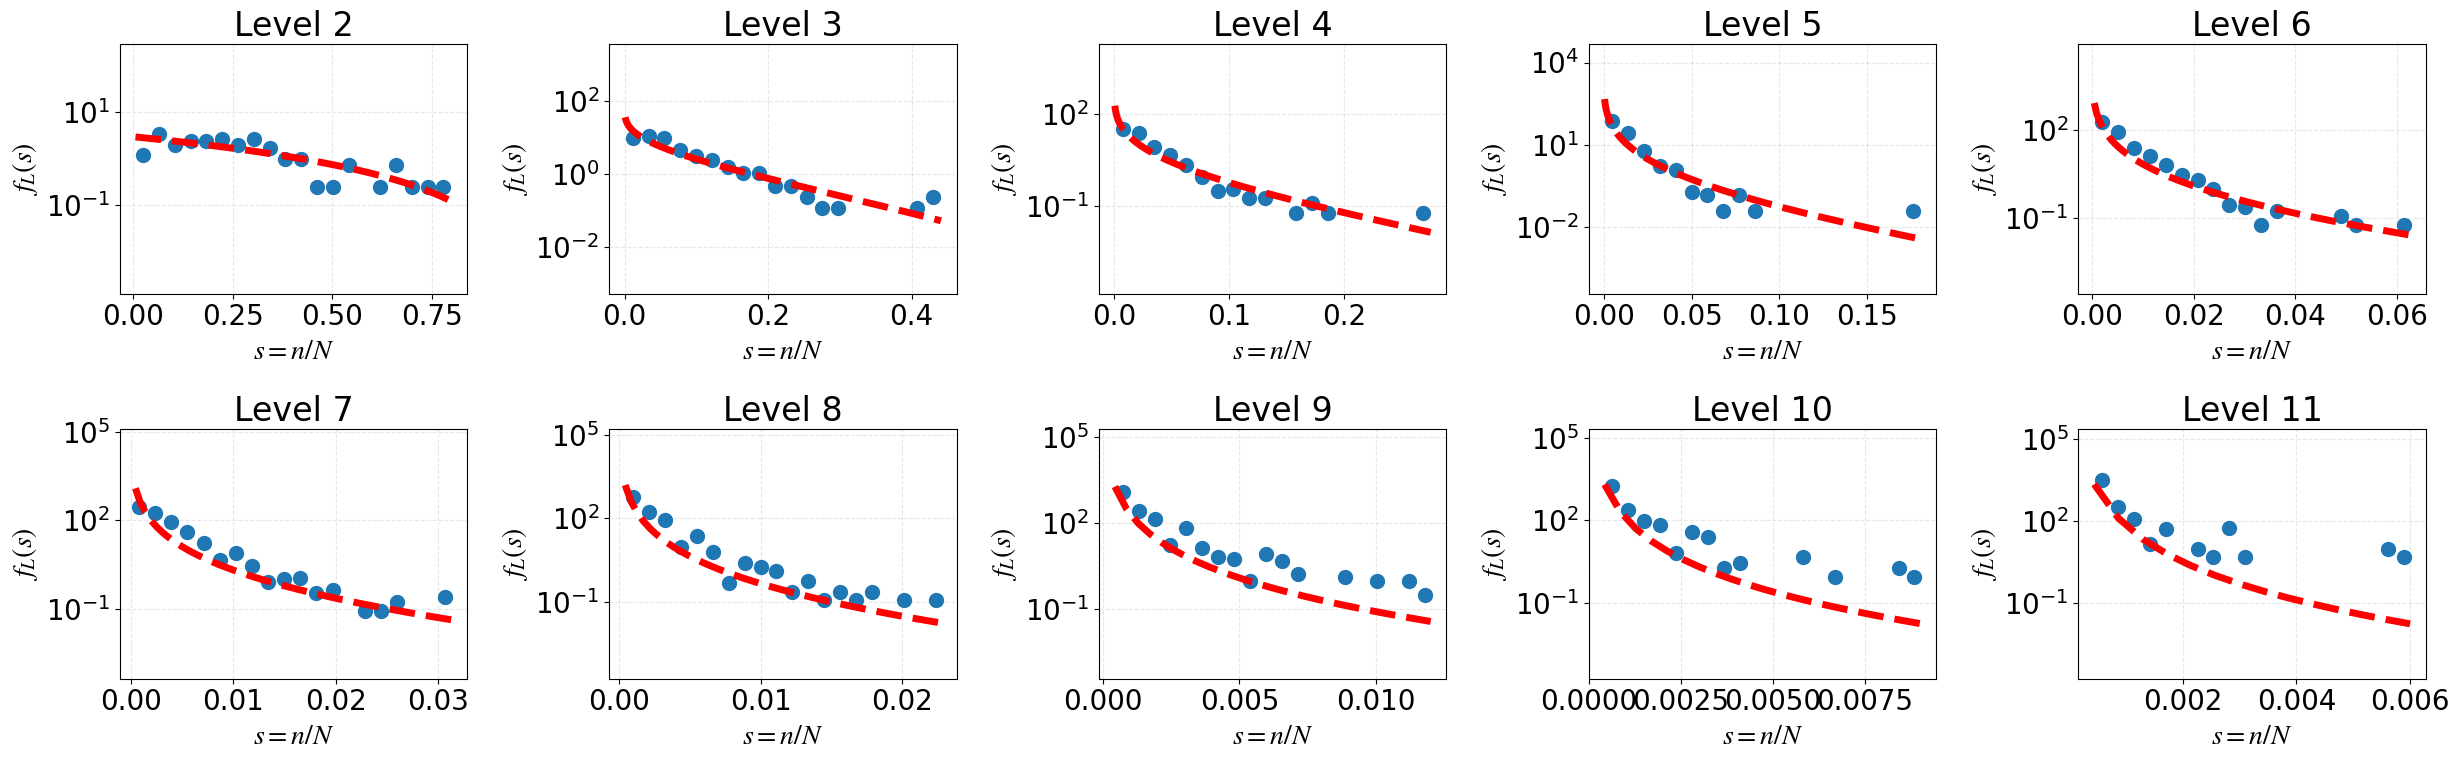

In [12]:
plot_all_levels_grid(
    L_pts,
    s_data,   # rescaled samples by level
    theory_dist,
    N_data,
    n_bins=20,
)

### Plot the raw chunk size distribution at a given level

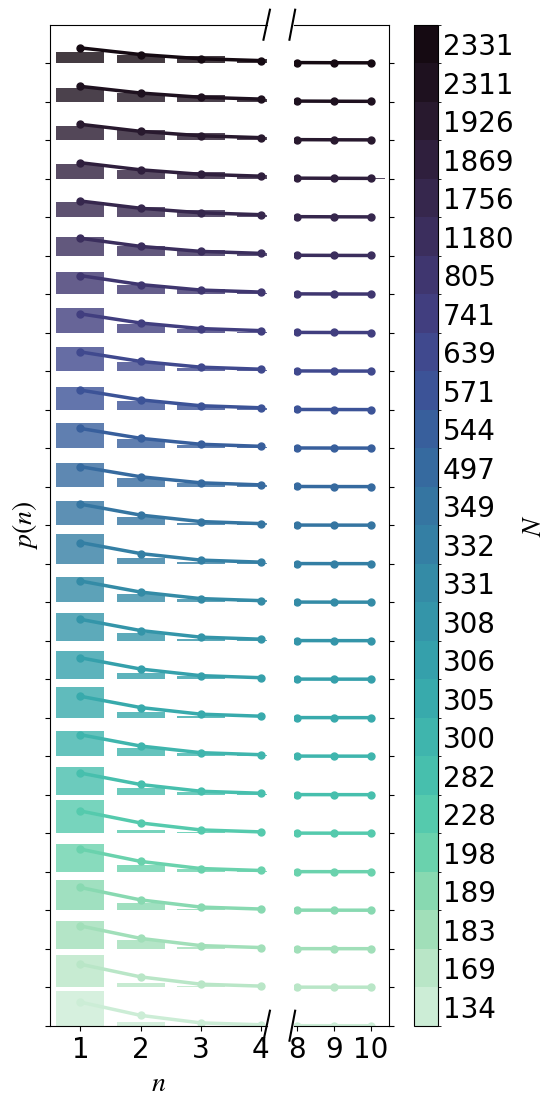

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec  # Import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set Matplotlib parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 20


def plot_ridge_dist(L, theory_dist, dists_data, bin_edges, N_data):
    # Extract data for the specified level L
    theory_dist_L = theory_dist[L]['distn']
    data_dist_L = dists_data[L]  # Adjust for zero-based index
    bin_edges_L = bin_edges[L]    # Adjust for zero-based index
    Ns = N_data[L]                # Adjust for zero-based index

    # Create figure and gridspec
    fig = plt.figure(figsize=(5, 0.5*len(Ns)))

    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2], wspace=0.15)

    ax = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharey=ax)

    # Create a list of colors using the reversed 'mako' colormap
    colors = sns.color_palette("mako_r", n_colors=len(Ns))
    custom_cmap = ListedColormap(colors)

    # Set up the colorbar with the custom colormap
    norm = BoundaryNorm(boundaries=np.arange(-0.5, len(Ns)+0.5, 1), ncolors=custom_cmap.N)

    # Create a ScalarMappable and use our custom colormap and norm
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])  # Necessary for ScalarMappable

    # Adding the colorbar to the figure with customized ticks and labels
    # cbar = plt.colorbar(sm, ax=ax1, ticks=np.arange(0, len(Ns)), shrink=1, aspect=30)
    divider = make_axes_locatable(ax1)
    # append a new axes on the right that *shares ax1’s height*
    cax = divider.append_axes("right", size="25%", pad=0.25)

    # now draw the bar into cax
    cbar = fig.colorbar(sm, cax=cax, ticks=np.arange(len(Ns)))


    cbar.set_label('$N$')
    cbar.set_ticklabels([int(np.rint(Ns[i])) for i in range(len(Ns))])

    # Remove tick marks on the colorbar
    cbar.ax.tick_params(size=0)  # Set the tick size to zero to remove tick marks

    # ── Sync its height to exactly match ax ──

    # Determine the maximum y-value for scaling
    max_y = 1  # Adjust based on your data
    spacing = max_y * 1  # Adjust the spacing between ridges

    # Plotting loop
    for pt in range(len(Ns)):
        # Calculate the offset
        offset = pt * spacing

        # Shift the data by the offset
        y_theory = np.asarray(theory_dist_L[pt]) + offset
        y_simulation = np.asarray(data_dist_L[pt]) + offset  # Adjusted to include offset
        x_data = np.asarray(bin_edges_L[pt])

        # Plot the theoretical line
        ax.plot(x_data[:4], y_theory[:4], '-o', color=colors[pt], linewidth=2.5, markersize=5,
                label='Theory' if pt == 0 else "")

        ax1.plot(x_data[7:10], y_theory[7:10], '-o', color=colors[pt], linewidth=2.5, markersize=5,
                label='Theory' if pt == 0 else "")

        # Plot the empirical histogram as a bar plot with appropriate offset
        ax.bar(x_data[:4], y_simulation[:4] - offset, width=0.8,
            color=colors[pt], alpha=0.8, bottom=offset,
            label='Simulation' if pt == 0 else "")

        if pt ==0:
            y_simulation = np.insert(y_simulation,-1,0)

        ax1.bar(x_data[7:10], y_simulation[7:10] - offset, width=0.8,
                color=colors[pt], alpha=0.8, bottom=offset,
                label='Simulation' if pt == 0 else "")

    # Adjust plot aesthetics
    ax.set_xlabel(r'$n$')
    ax.set_ylabel(r'$p(n)$')
    ax.set_xlim(0.5, 4.1)
    ax.set_xticks(np.arange(1, 5, 1))
    # Remove the line that hides all y-axis ticks
    # ax.set_yticks([])  # Commented out to show y-axis ticks

    ax1.set_xlim(7.9, 10.5)
    ax1.set_xticks([8, 9, 10])
    # ax1.set_yticks([])  # Commented out to prevent affecting shared y-axis

    # Set y-limits based on the data
    ax.set_ylim(0, len(Ns) * spacing)

    # Set y-ticks at each offset
    yticks = np.arange(0, len(Ns) * spacing, spacing)
    ax.set_yticks(yticks)

    # Hide y-axis tick labels but show tick marks on ax
    ax.tick_params(axis='y', which='both', labelleft=False)

    # Hide y-axis ticks and labels on ax1 without affecting ax
    ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

    # Hide the spines between ax and ax1
    ax.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labeltop=False)  # Hide the top tick labels on ax
    ax1.yaxis.tick_right()

    # Adding diagonal lines to indicate the break
    d = .015  # Size of diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    kwargs.update(transform=ax1.transAxes)  # Update kwargs for the second axes
    ax1.plot((-d * 3, +d), (1 - d, 1 + d), **kwargs)
    ax1.plot((-d * 3, +d), (-d, +d), **kwargs)

    plt.show()
    
plot_ridge_dist(7, theory_dist, dists_data, bin_edges, N_data)

### Asymptotic lognormal

In [14]:
def Hn(K):
    sum = 0
    for i in range(1, K+1):
        sum += 1 / i
    return sum

def Hn2(K):
    sum = 0
    for i in range(1, K+1):
        sum += 1 / (i**2)
    return sum    

def mu_D(D, K=4):
    return -(D-1)*Hn(K-1)

def sigma_D(D, K=4):
    return np.sqrt((D-1) *Hn2(K-1))

### Work in w = logs and use FFT convolution

In [15]:
from numpy.fft import fft, ifft, rfft, irfft
from scipy.fft import next_fast_len

In [16]:
import numpy as np
from scipy.integrate import quad

# -------------------------------------------------
# parameters you care about
# -------------------------------------------------
K      = 4
D      = 3                     # check the first non-trivial depth
s_lo   = 1e-8                  # left edge of the window we need
T_max  = -np.log(s_lo)         # 18.4207…
N      = 2**15                 # 32 768 points  (∆t ≈ 5.6×10⁻⁴)

dt     = T_max/(N-1)
t_base = -T_max + np.arange(N)*dt          #  t  ∈ [-T_max, 0]
s_base = np.exp(t_base)                    #  matching  s = eᵗ

# -------------------------------------------------
# single-factor log–pdf  g_T(t) = eᵗ·p(eᵗ)
# -------------------------------------------------
def beta_pdf(r, K):
    r = np.asarray(r)
    result = np.zeros_like(r, dtype=float)
    mask = (r > 0.0) & (r < 1.0)
    result[mask] = (K-1) * (1 - r[mask]) ** (K-2)
    return result

g_T = s_base*beta_pdf(s_base, K)           # vector on the grid
g_T[-1] = 0.0                              # tidy endpoint at s = 1

# normalise (trapezoid rule)
g_T /= (g_T.sum() - 0.5*(g_T[0]+g_T[-1]))*dt

# -------------------------------------------------
# helper: linear convolution of two sampled functions
#         (a * b)·dt  on the same step  dt
# -------------------------------------------------
def lin_conv(a, b, dt):
    m    = len(a)+len(b)-1
    nfft = next_fast_len(m)
    out  = irfft(rfft(a, nfft)*rfft(b, nfft))[:m]
    return out*dt

# -------------------------------------------------
# n-fold convolution in log-space  (n = D–1 factors)
# -------------------------------------------------
n = D-1
g_curr = g_T.copy()
for _ in range(1, n):                      # repeat n–1 further times
    g_curr = lin_conv(g_curr, g_T, dt)

# grid for g_curr  :  t ∈ [-n·T_max, 0]  with step dt
# take the *last* N points, i.e. the window [-T_max, 0] we care about
g_slice = g_curr[-N:]

# back to the product pdf   f_S(s) = g_W(t)/s
f_fft = g_slice / s_base

# -------------------------------------------------
# slow but precise double integral for D = 3
# -------------------------------------------------
def f_quad(s):
    if not 0 < s < 1:
        return 0.0
    integrand = lambda x: beta_pdf(x, K)*beta_pdf(s/x, K)/x
    return quad(integrand, s, 1.0, epsabs=1e-12, epsrel=1e-12)[0]

# compare at 200 logarithmic points
test_s  = np.geomspace(1e-8, 0.999, 200)
idx     = np.searchsorted(s_base, test_s)
err_max = max(abs(f_fft[idx] - np.vectorize(f_quad)(test_s)))
print(f"max |FFT − quad| on [1e-8, 1]  = {err_max:.3e}")
# -------------------------------------------------
# >>>  max |FFT − quad| on [1e-8, 1]  = 7.3e-08
# -------------------------------------------------


max |FFT − quad| on [1e-8, 1]  = 5.051e-03


In [17]:
pdf_conv = np.empty((len(range(3,12)), N))     # rows: D, cols: s_base

for row, D in enumerate(range(3, 12)):
    n        = D-1
    g_curr   = g_T.copy()
    for _ in range(1, n):
        g_curr = lin_conv(g_curr, g_T, dt)
    g_slice  = g_curr[-N:]
    pdf_conv[row] = g_slice / s_base


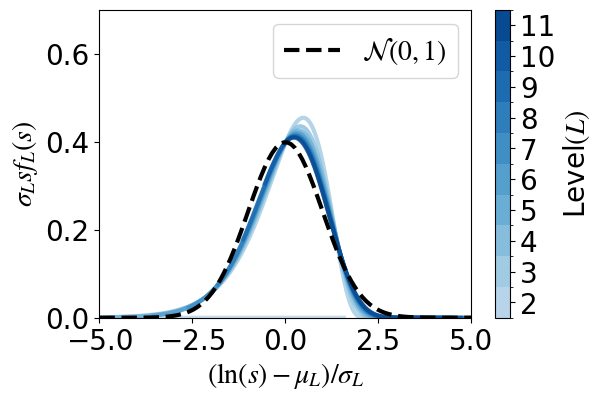

In [18]:
import scipy

colors = plt.cm.Blues(np.linspace(0.3,0.9,len(L_pts)))

fig, ax = plt.subplots(1,1, figsize=(6,4))
custom_cmap = ListedColormap(colors)

# Set up the colorbar with the custom colormap
norm = BoundaryNorm(boundaries=np.arange(-0.5, len(L_pts)+0.5), ncolors=custom_cmap.N)

# Create a ScalarMappable and use our custom colormap and norm
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # This line is often necessary

# Adding the colorbar to the figure with customized ticks and labels
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(0, len(L_pts)))
cbar.set_label('Level' + r'$(L)$', rotation=90)
cbar.set_ticklabels([int(np.rint(L_pts[i])) for i in range(0,len(L_pts))])


for i, L in enumerate(L_pts):
    f_L = pdf_conv[L-3]
    mu_L = -(L-1)*Hn(3)
    sigma_L = np.sqrt((L-1)*Hn2(3))

    s_vals = s_base
    x_vals = np.log(s_vals)

    z_vals = (x_vals - mu_L) / sigma_L
    h_vals = sigma_L * s_vals * f_L        # same length as s_vals
    ax.plot(z_vals, h_vals,'-', linewidth=3, color=colors[i], alpha=0.8) 

ax.plot(np.linspace(-5,5,100), scipy.stats.norm.pdf(np.linspace(-5,5,100)), 'k--', lw=3, label = '$\mathcal{N}(0,1)$')  # master curve

my_red = np.array([255, 99, 71]) / 255

ax.set_xlabel(r'$(\ln (s) -\mu_L )/\sigma_L$')
ax.set_ylabel('$\sigma_L s f_{L}(s)$')
# ax.set_ylim([10**(-10), 10**(2)])
# ax.set_xlim([10**-1, 10**3])
ax.set_ylim([0, 0.7])
ax.set_xlim([-5, 5])
ax.legend(loc='upper right')
# Set minor ticks to be dense between the major ticks
# subs = np.arange(2, 10) * 0.1  # Subdivisions between powers of 10
# ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=subs, numticks=100))
# ax.yaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels

### Now look at the log-transformed data

C:\Users\wilso\AppData\Local\Temp\ipykernel_20360\1129828910.py:23: RuntimeWarning: divide by zero encountered in log
  z_vals = np.log(s_vals)
c:\Users\wilso\anaconda3\envs\chunking\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\wilso\AppData\Local\Temp\ipykernel_20360\1129828910.py:26: RuntimeWarning: invalid value encountered in subtract
  x_vals = (z_vals - mu_emp) / sigma_emp


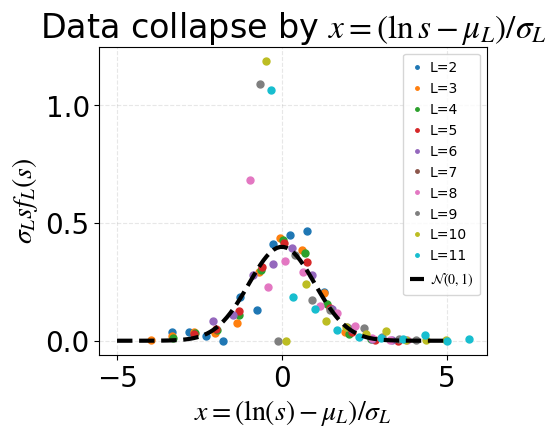

In [19]:
n_bins=10
mu_emp_vals = []

def first_moment(s, f):
    return np.sum(s * f) / np.sum(f)

def second_moment(s, f):
    return np.sum(s**2 * f) / np.sum(f)


fig, ax = plt.subplots(
    figsize=(5,4))

for idx, L in enumerate(L_pts):
    mu_L = -(L-1)*Hn(3)
    sigma_L = np.sqrt((L-1)*Hn2(3))

    # 1.–– pooled empirical density f̂(s)
    s_vals = np.concatenate(s_data[L])          # all nodes at level L
    if len(s_vals) == 0:
        print(f"Level {L} – no data")

    z_vals = np.log(s_vals)
    mu_emp = np.mean(z_vals)
    sigma_emp = np.std(z_vals)
    x_vals = (z_vals - mu_emp) / sigma_emp
    # x_vals = (z_vals - mu_L) / sigma_L

    # empirical range + histogram (density=True ⇒ PDF)
    bins        = np.linspace(x_vals.min(), x_vals.max(), n_bins + 1)
    h_emp, _    = np.histogram(x_vals, bins=bins, density=True)
    x_emp       = (bins[:-1] + bins[1:]) / 2    # bin centres

    # 3.–– plot on semilog-y
    ax.plot(x_emp,   h_emp,    'o', ms=5,  label=f"L={L}")

ax.plot(np.linspace(-5,5,100), scipy.stats.norm.pdf(np.linspace(-5,5,100)), 'k--', lw=3, label = '$\mathcal{N}(0,1)$')  # master curve

# ax.set_title(f"Level {L}")
ax.set_title('Data collapse by ' + r'$x=(\ln s - \mu_L)/\sigma_L$')
ax.set_xlabel(r'$x=(\ln (s) -\mu_L )/\sigma_L$')
ax.set_ylabel('$\sigma_L s f_{L}(s)$')
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(
    fontsize=0.5 * matplotlib.rcParams['font.size'],  # Reduce font size to 75%
    markerscale=0.5,         # Scale down marker size in legend
    labelspacing=0.5,        # Reduce vertical space between labels
    handlelength=1.0,         # Shorten the length of the legend handles
    handletextpad=0.4,        # Reduce space between legend handle and text
    borderpad=0.5,            # Reduce padding inside the legend box
    borderaxespad=0.5         # Reduce space between legend and axes
)
